In [1]:
print("Help I'm stuck in a computer!")

Help I'm stuck in a computer!


In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
from scipy.optimize import root
from scipy.special import erf

In [2]:
#Load without import (So I won't need to restart the kernel all the time)
with open("molecule.py") as f: exec(f.read())
with open("simulation.py") as f: exec(f.read())
with open("multispecies_simulation.py") as f: exec(f.read())
# from molecule import *
# from simulation import *
# from multispecies_simulation import *

In [3]:
import json
def read_parameters(filename):
    with open(filename) as f:
        return json.loads(f.read())

In [6]:

params = read_parameters("setups/tracking_range.json")

In [7]:
params

{'background_noise_sigma': 0.1,
 'diffusion_coefficient_in_um^2_over_seconds': 0.5,
 'number_of_frames': 250,
 'number_of_molecules': 5000,
 'number_of_subframes_per_frame': 100,
 'pixel_length_in_um': 0.117,
 'screen_size_in_pixels_x': 400,
 'screen_size_in_pixels_y': 400,
 'sigma_x_noise_in_um': 0.04,
 'sigma_y_noise_in_um': 0.04,
 'total_time_in_seconds': 10,
 'z_direction_depth_in_um': 0.5}

In [5]:
params = read_parameters("setups/tracking_range.json")
diffs = np.linspace(.2,.8,20)
for diff in tqdm(diffs):
    diff = round(diff, 2)
    params[DIFFUSION_COEFFICIENT_KEY] = diff
    sim = Simulation(params)
    sim.run(verbose = False)
    sim.save_animation("./Animation TIF Files/tracking_range_({}).tif".format(diff), verbose = False)

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

KeyboardInterrupt: 

In [7]:
import datetime
print(datetime.datetime.now())
params = read_parameters("setups/for_tracking.json")
sim = Simulation(params)
sim.run()
sim.save_animation("./Animation TIF Files/_test_animation.tif")
print(datetime.datetime.now())

2019-05-14 22:43:14.756115


HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))



2019-05-14 22:45:41.148900


In [4]:
def MSD_for_limited_steps(sigma, L):
    #defined in my notes
    
    #One Dimention
    #return -(np.sqrt(2/np.pi))*np.exp(-L**2/(2*sigma**2))/(erf(L/(np.sqrt(2)*sigma))) *L*sigma + sigma**2
    
    #Two Dimentions
    z = L**2/(2*sigma**2)
    return -(L)**2/2*(np.exp(-z))/(1-np.exp(-z)) + sigma**2

def sigma_for_MSD(MSD, L):
    return root(lambda s:MSD_for_limited_steps(s, L) - MSD, 0.01, method='hybr')

In [5]:
folders = glob("./Animation TIF Files/Track*/")

In [6]:
folder = "./Animation TIF Files/TrackingRange0d77D/" 
folder = "./Animation TIF Files/TrackingRange0d48D/" 
folder = "./Animation TIF Files/TrackingRange0d58D/" 

results = {}

for folder in tqdm(sorted(folders)):
    if "d77" in folder:
        continue
    original = float('0'+folder[-5:-1].replace("D","").replace("d","."))
    if original > .99:
        continue
    results[folder] = []
    for i in range(3,8):
        df = pd.read_csv(folder + "tracks_{}steps.csv".format(i))
        params = read_parameters("./setups/tracking_range.json")
        pixel_in_um = params['pixel_length_in_um']
        dt = params['total_time_in_seconds'] / params['number_of_frames']

        #Ignore 0's in the data
        steps = [np.diff(ar)[((np.roll(ar,-1) != 0 ) & (ar != 0))[:-1]] * pixel_in_um
                         for ar in df.to_numpy().T]
        number_of_steps = sum(map(len, steps))
        #     print(number_of_steps)

        steps_squared = list(map(lambda x:np.sum(x**2), steps))
        mean_square_dis = np.sum(steps_squared)/number_of_steps 
        res = (sigma_for_MSD(mean_square_dis, i*pixel_in_um))
        diffusion_coef = res.x[0]**2/ 2 / dt
        results[folder].append((original, diffusion_coef*(3/2), mean_square_dis/2/dt, i, len(df.columns)))

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

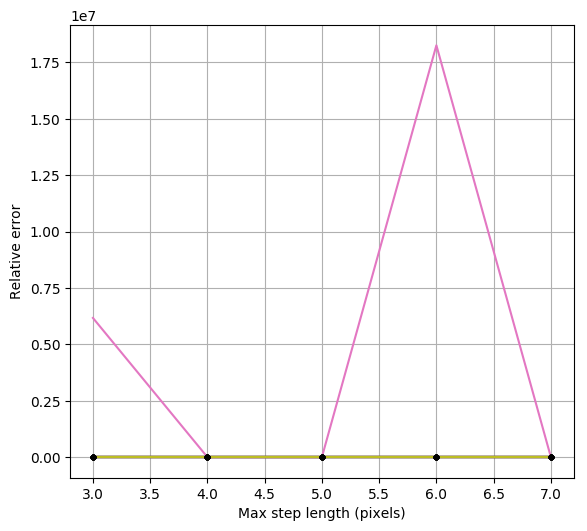

In [7]:
plt.figure()
for key, value in results.items():
    t1 = np.array(value).T[[1,3]][::-1]
    t2 = np.array(value).T[[0,3]][::-1]
    plt.plot(t1[0], (t1 - t2)[1]/t2[1])
plt.xlabel("Max step length (pixels)")
plt.ylabel("Relative error")
for key, value in results.items():
    t1 = np.array(value).T[[2,3]][::-1]
    t2 = np.array(value).T[[0,3]][::-1]
    plt.plot(t1[0], (t1 - t2)[1]/t2[1], '.k')
plt.grid()

In [30]:
X = []
Y = []
Ns = []
for value in results.values():
    print(value[1])
    a,b,_,_,n = value[0]
    if a > .6:
        continue
    X.append(a)
    Y.append(b)
    Ns.append(n)

(0.45, 0.4872404838525197, 0.30428618762732473, 4, 412)
(0.58, 0.5882753471357307, 0.3491376745106248, 4, 218)
(0.33, 0.3450227871189713, 0.2264435600434742, 4, 596)
(0.42, 0.44254277181021406, 0.28167769213347393, 4, 438)
(0.67, 1.3869220724228877, 0.5214255264247136, 4, 180)
(0.74, 0.9715593760899695, 0.45958819917119315, 4, 106)
(0.8, 5.258146781624183, 0.6400155770960392, 4, 114)
(0.48, 0.5431313377343666, 0.3301347790636665, 4, 340)
(0.64, 0.6623927302343094, 0.37701127047717387, 4, 132)
(0.71, 1.012299934038913, 0.4675178411457583, 4, 124)
(0.55, 0.624395546212822, 0.36321319326539653, 4, 220)
(0.2, 0.252303843443077, 0.16780258466779446, 4, 964)
(0.29, 0.3213632334353037, 0.21193977309682566, 4, 698)
(0.23, 0.26621242501387254, 0.17686293070229528, 4, 996)
(0.39, 0.41924860560254845, 0.2692050430177684, 4, 460)
(0.61, 0.6607962724735013, 0.37645139937531963, 4, 192)
(0.52, 0.5063092350390899, 0.3134032237299509, 4, 256)
(0.36, 0.3684437685486814, 0.240408988027937, 4, 616)
(0.26

For future reference :

$$I(D) = \frac{1}{D^2}-\frac{L^4 \text{csch}^2\left(\frac{L^2}{8 D t}\right)}{64 D^4 t^2}$$

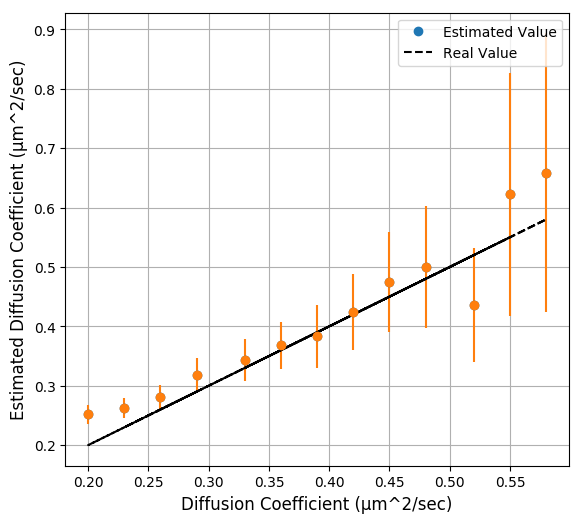

In [57]:
plt.plot(X, Y, 'o')
plt.plot(X, X, '--k')
plt.xlabel("Diffusion Coefficient (µm^2/sec)",fontsize = 12)
plt.ylabel("Estimated Diffusion Coefficient (µm^2/sec)",fontsize = 12)
plt.legend(["Estimated Value","Real Value"])
L = 3*.117
errors = 1/np.sqrt(1/(Y**2) - L**4 /(np.sinh(L**2 / (8 * Y * dt)))**2/ (64*Y**4*dt**2))
Y = np.array(Y)
Ns = np.array(Ns)
errs = (np.array(Y))
plt.errorbar(X, Y, yerr=errors/np.sqrt(Ns/2),fmt='o')
plt.grid()


array([0.47480592, 0.65873776, 0.3435241 , 0.42466404, 0.4996219 ,
       0.62212151, 0.25164189, 0.31823434, 0.26315572, 0.38303436,
       0.43641089, 0.36792723, 0.28181427])

In [ ]:
np.